# Vibration Signal Analysis for Mechanical Wear Detection

This notebook demonstrates computational physics techniques for detecting abnormal vibrations in rotating machinery. We'll explore how signal processing methods can extract physically meaningful information from noisy vibration data.

## Physics Background

In rotating systems, vibration arises from Newton's second law: time-dependent forces produce accelerations that can be measured as vibration. Mechanical wear introduces additional forces that act periodically, leading to:
- New frequency components in the vibration signal
- Increased broadband noise
- Changes in the frequency spectrum that can be detected computationally

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from signal_generator import VibrationSignalGenerator
from vibration_analysis import VibrationAnalyzer
import ipywidgets as widgets
from IPython.display import display

# Set up plotting parameters
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

## 1. Signal Generation and Mathematical Model

We implement the vibration signal model:

$$x(t) = A_0 \sin(2\pi f_0 t) + \sum_k A_k \sin(2\pi f_k t) + \eta(t)$$

Where:
- $f_0$ is the rotation frequency
- $A_0$ is the fundamental amplitude  
- $f_k, A_k$ represent additional frequency components from wear
- $\eta(t)$ is stochastic noise

In [2]:
# Initialize signal generator and analyzer
fs = 1000  # Sampling frequency (Hz)
generator = VibrationSignalGenerator(sampling_frequency=fs)
analyzer = VibrationAnalyzer(sampling_frequency=fs)

# Signal parameters
duration = 2.0  # seconds
rotation_freq = 25.0  # Hz (1500 RPM)

print(f"Sampling frequency: {fs} Hz")
print(f"Signal duration: {duration} s")
print(f"Rotation frequency: {rotation_freq} Hz ({rotation_freq*60:.0f} RPM)")

Sampling frequency: 1000 Hz
Signal duration: 2.0 s
Rotation frequency: 25.0 Hz (1500 RPM)


## 2. Healthy vs. Worn Machine Comparison

Let's generate signals representing different levels of mechanical wear and observe how the physics changes.

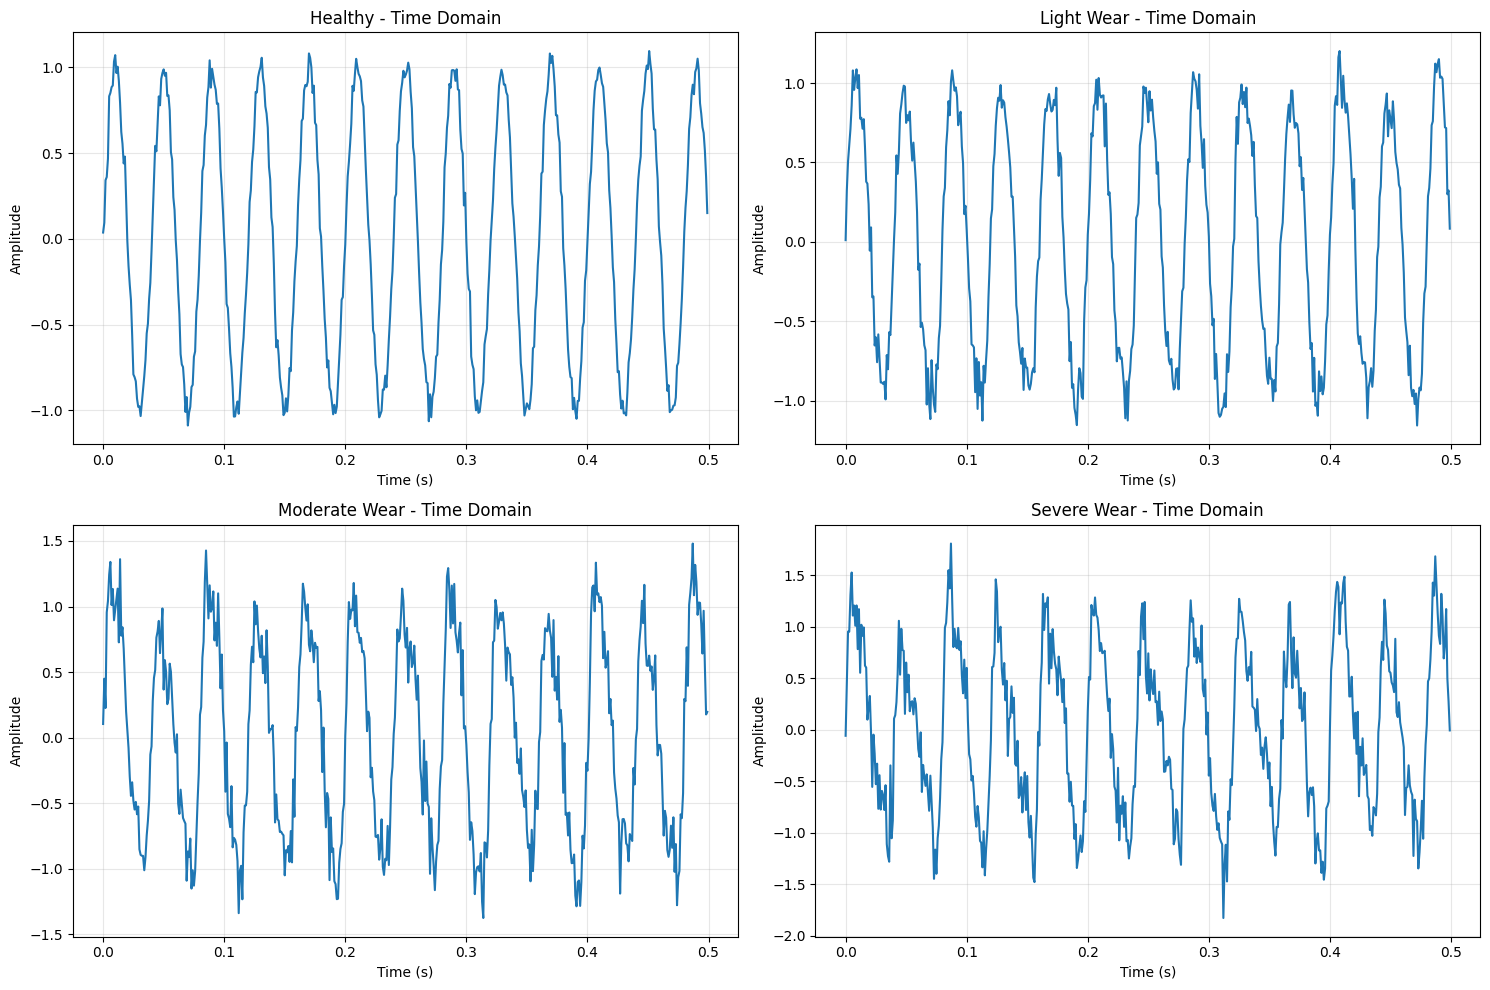

In [3]:
# Generate signals for different wear levels
wear_levels = [0.0, 0.3, 0.7, 1.0]  # 0 = healthy, 1 = severe wear
wear_labels = ['Healthy', 'Light Wear', 'Moderate Wear', 'Severe Wear']

signals = generator.generate_wear_progression(duration, rotation_freq, wear_levels)

# Plot time domain signals
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for i, ((t, signal), label) in enumerate(zip(signals, wear_labels)):
    axes[i].plot(t[:500], signal[:500])  # Show first 0.5 seconds
    axes[i].set_title(f'{label} - Time Domain')
    axes[i].set_xlabel('Time (s)')
    axes[i].set_ylabel('Amplitude')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 3. Frequency Domain Analysis using FFT

The discrete Fourier transform reveals the frequency content:

$$X_k = \sum_{n=0}^{N-1} x_n e^{-2\pi ikn/N}$$

Peaks in the magnitude spectrum $|X_k|$ correspond to dominant periodic components.

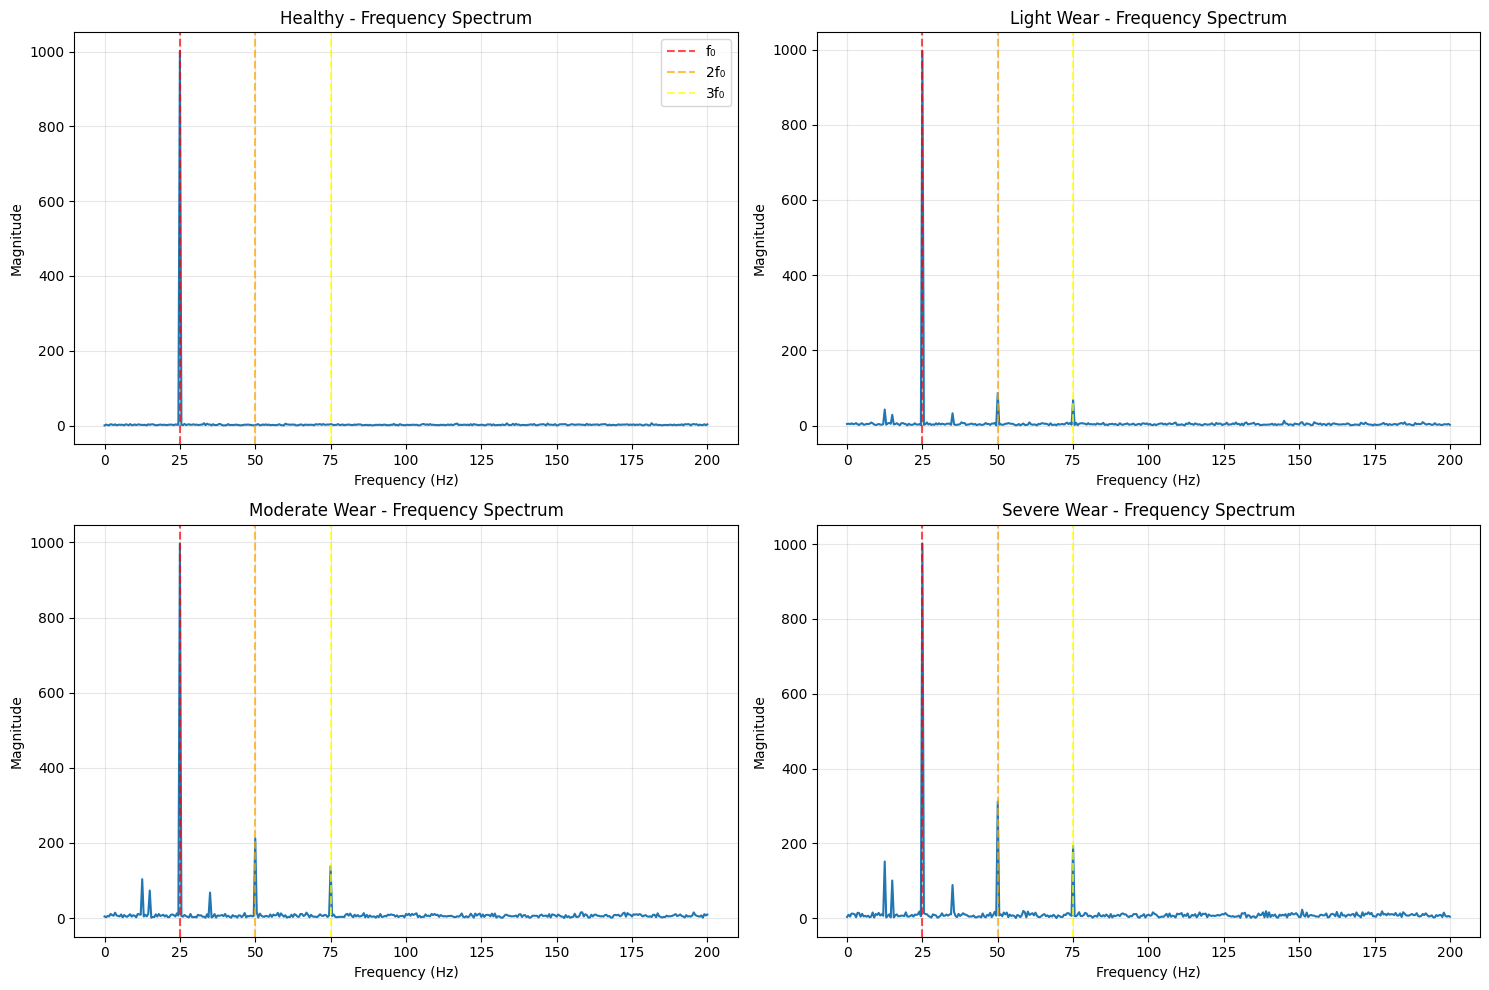

In [4]:
# Compute and plot frequency spectra
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for i, ((t, signal), label) in enumerate(zip(signals, wear_labels)):
    # Compute FFT
    frequencies, magnitude = analyzer.compute_fft(signal)
    
    # Plot magnitude spectrum (up to 200 Hz)
    freq_mask = frequencies <= 200
    axes[i].plot(frequencies[freq_mask], magnitude[freq_mask])
    axes[i].set_title(f'{label} - Frequency Spectrum')
    axes[i].set_xlabel('Frequency (Hz)')
    axes[i].set_ylabel('Magnitude')
    axes[i].grid(True, alpha=0.3)
    
    # Mark rotation frequency and harmonics
    axes[i].axvline(rotation_freq, color='red', linestyle='--', alpha=0.7, label='f₀')
    axes[i].axvline(2*rotation_freq, color='orange', linestyle='--', alpha=0.7, label='2f₀')
    axes[i].axvline(3*rotation_freq, color='yellow', linestyle='--', alpha=0.7, label='3f₀')
    if i == 0:
        axes[i].legend()

plt.tight_layout()
plt.show()

## 4. Digital Filtering for Frequency Isolation

Digital filters isolate specific frequency ranges to focus on wear-related components.

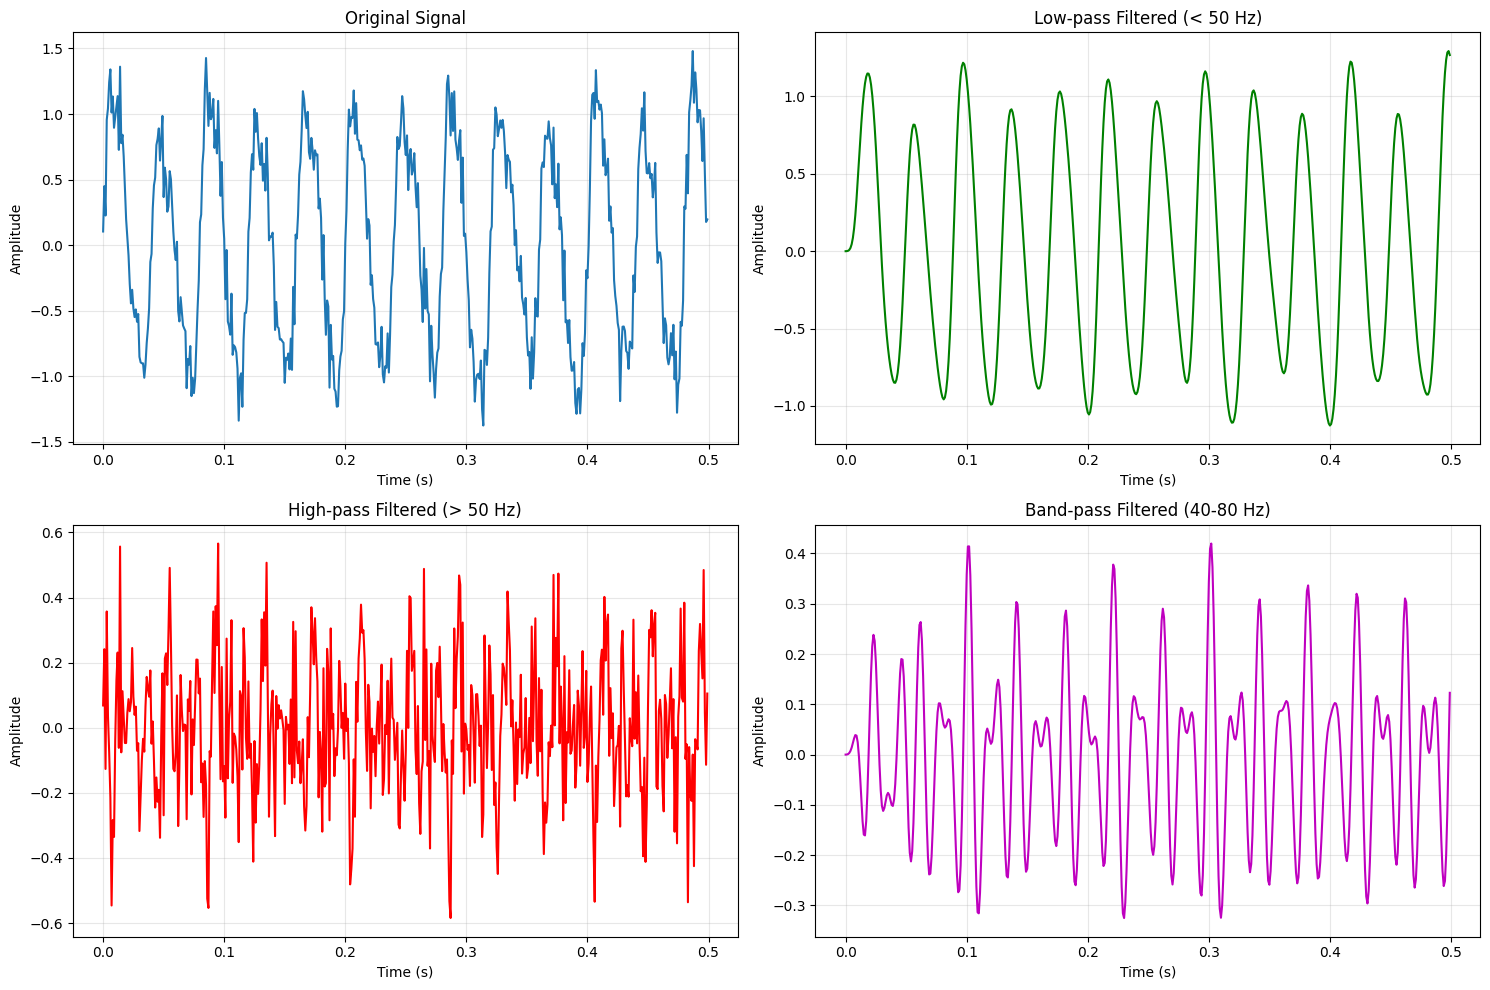

In [5]:
# Demonstrate filtering on a moderately worn signal
t, worn_signal = signals[2]  # Moderate wear

# Apply different filters
lowpass_signal = analyzer.apply_filter(worn_signal, 'lowpass', 50)
highpass_signal = analyzer.apply_filter(worn_signal, 'highpass', 50)
bandpass_signal = analyzer.apply_filter(worn_signal, 'bandpass', [40, 80])

# Plot filtered signals
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Time domain
time_slice = slice(0, 500)  # First 0.5 seconds
axes[0,0].plot(t[time_slice], worn_signal[time_slice], label='Original')
axes[0,0].set_title('Original Signal')
axes[0,0].set_xlabel('Time (s)')
axes[0,0].set_ylabel('Amplitude')
axes[0,0].grid(True, alpha=0.3)

axes[0,1].plot(t[time_slice], lowpass_signal[time_slice], 'g', label='Low-pass (<50 Hz)')
axes[0,1].set_title('Low-pass Filtered (< 50 Hz)')
axes[0,1].set_xlabel('Time (s)')
axes[0,1].set_ylabel('Amplitude')
axes[0,1].grid(True, alpha=0.3)

axes[1,0].plot(t[time_slice], highpass_signal[time_slice], 'r', label='High-pass (>50 Hz)')
axes[1,0].set_title('High-pass Filtered (> 50 Hz)')
axes[1,0].set_xlabel('Time (s)')
axes[1,0].set_ylabel('Amplitude')
axes[1,0].grid(True, alpha=0.3)

axes[1,1].plot(t[time_slice], bandpass_signal[time_slice], 'm', label='Band-pass (40-80 Hz)')
axes[1,1].set_title('Band-pass Filtered (40-80 Hz)')
axes[1,1].set_xlabel('Time (s)')
axes[1,1].set_ylabel('Amplitude')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Quantitative Wear Indicators

We compute physics-based indicators that quantify the progression of mechanical wear.

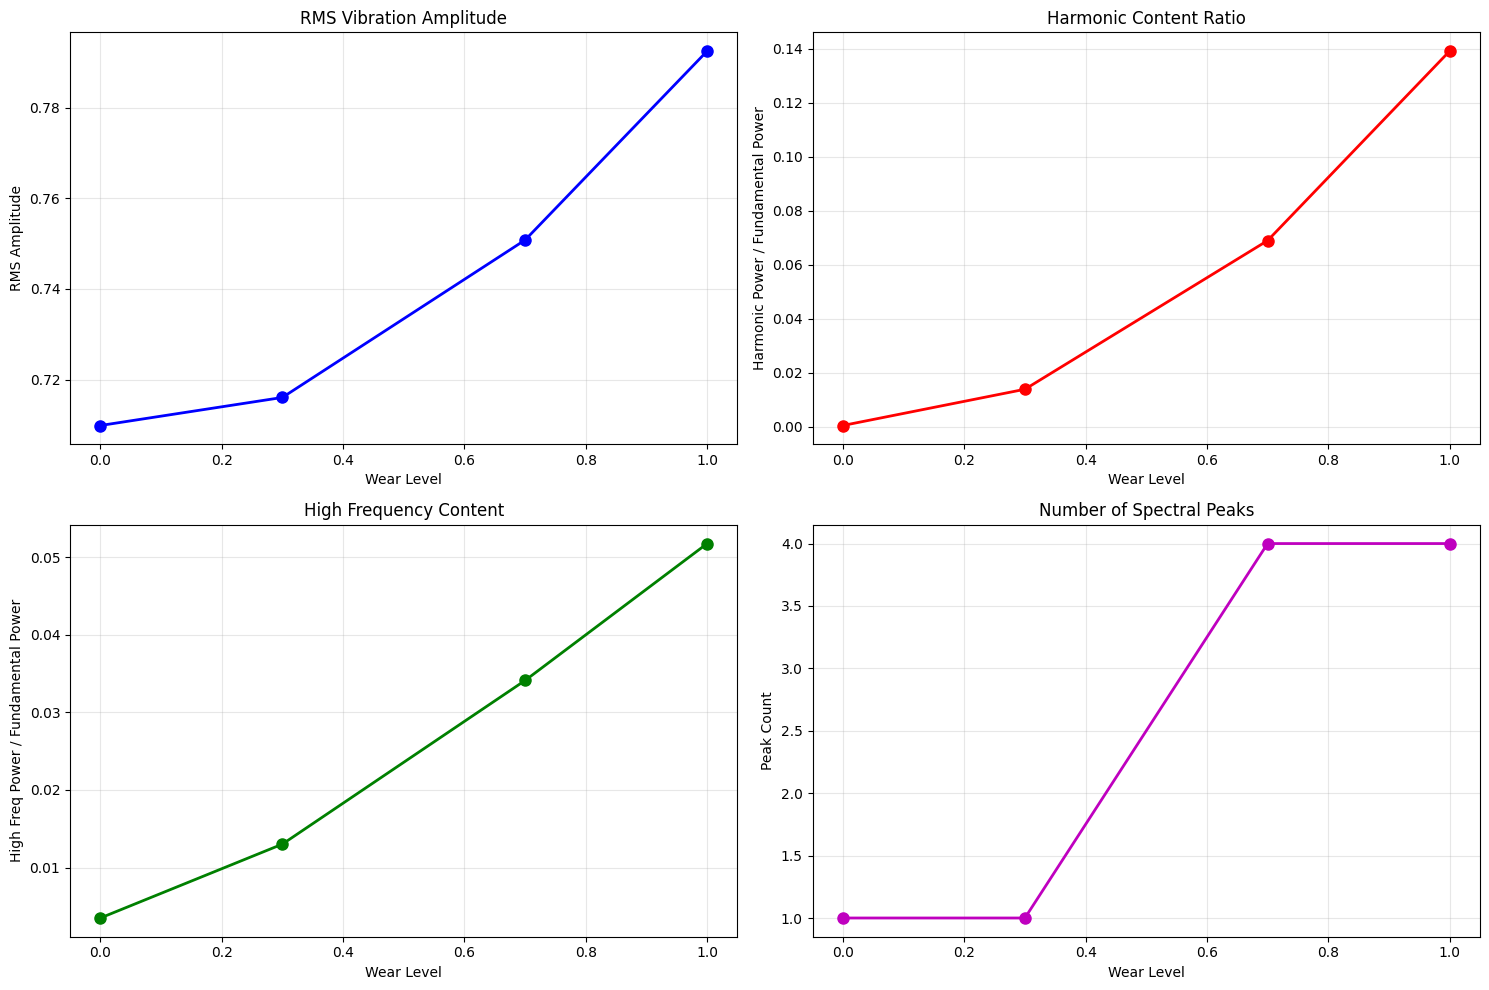


Wear Progression Analysis:
Healthy         | RMS: 0.710 | Harmonic Ratio: 0.000 | HF Ratio: 0.004 | Peaks: 1
Light Wear      | RMS: 0.716 | Harmonic Ratio: 0.014 | HF Ratio: 0.013 | Peaks: 1
Moderate Wear   | RMS: 0.751 | Harmonic Ratio: 0.069 | HF Ratio: 0.034 | Peaks: 4
Severe Wear     | RMS: 0.793 | Harmonic Ratio: 0.139 | HF Ratio: 0.052 | Peaks: 4


In [6]:
# Analyze wear indicators for all signals
wear_indicators = []

for t, signal in signals:
    indicators = analyzer.analyze_wear_indicators(signal, rotation_freq)
    wear_indicators.append(indicators)

# Extract key metrics
rms_values = [ind['overall_rms'] for ind in wear_indicators]
harmonic_ratios = [ind['harmonic_ratio'] for ind in wear_indicators]
high_freq_ratios = [ind['high_freq_ratio'] for ind in wear_indicators]
peak_counts = [ind['peak_count'] for ind in wear_indicators]

# Plot wear progression
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0,0].plot(wear_levels, rms_values, 'bo-', linewidth=2, markersize=8)
axes[0,0].set_title('RMS Vibration Amplitude')
axes[0,0].set_xlabel('Wear Level')
axes[0,0].set_ylabel('RMS Amplitude')
axes[0,0].grid(True, alpha=0.3)

axes[0,1].plot(wear_levels, harmonic_ratios, 'ro-', linewidth=2, markersize=8)
axes[0,1].set_title('Harmonic Content Ratio')
axes[0,1].set_xlabel('Wear Level')
axes[0,1].set_ylabel('Harmonic Power / Fundamental Power')
axes[0,1].grid(True, alpha=0.3)

axes[1,0].plot(wear_levels, high_freq_ratios, 'go-', linewidth=2, markersize=8)
axes[1,0].set_title('High Frequency Content')
axes[1,0].set_xlabel('Wear Level')
axes[1,0].set_ylabel('High Freq Power / Fundamental Power')
axes[1,0].grid(True, alpha=0.3)

axes[1,1].plot(wear_levels, peak_counts, 'mo-', linewidth=2, markersize=8)
axes[1,1].set_title('Number of Spectral Peaks')
axes[1,1].set_xlabel('Wear Level')
axes[1,1].set_ylabel('Peak Count')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print quantitative results
print("\nWear Progression Analysis:")
print("=" * 50)
for i, (level, label) in enumerate(zip(wear_levels, wear_labels)):
    print(f"{label:15} | RMS: {rms_values[i]:.3f} | Harmonic Ratio: {harmonic_ratios[i]:.3f} | HF Ratio: {high_freq_ratios[i]:.3f} | Peaks: {peak_counts[i]}")

## 6. Interactive Parameter Exploration

Use the interactive widgets below to explore how different parameters affect the vibration signal and its detection.

In [7]:
def interactive_analysis(wear_level=0.5, noise_level=0.1, rotation_rpm=1500):
    """
    Interactive function to explore parameter effects on vibration analysis.
    """
    rotation_freq = rotation_rpm / 60  # Convert RPM to Hz
    
    # Generate signal with custom parameters
    wear_components = [
        (2 * rotation_freq, 0.3 * wear_level),
        (3 * rotation_freq, 0.2 * wear_level),
        (0.5 * rotation_freq, 0.15 * wear_level),
        (rotation_freq + 10, 0.1 * wear_level),
        (rotation_freq - 10, 0.1 * wear_level)
    ]
    
    t, signal = generator.generate_signal(
        duration=2.0,
        rotation_freq=rotation_freq,
        wear_components=wear_components,
        noise_amplitude=noise_level
    )
    
    # Analyze signal
    indicators = analyzer.analyze_wear_indicators(signal, rotation_freq)
    frequencies = indicators['frequencies']
    magnitude = indicators['magnitude']
    
    # Create plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Time domain plot
    time_slice = slice(0, 500)
    ax1.plot(t[time_slice], signal[time_slice])
    ax1.set_title(f'Time Domain Signal (Wear: {wear_level:.1f}, Noise: {noise_level:.2f})')
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Amplitude')
    ax1.grid(True, alpha=0.3)
    
    # Frequency domain plot
    freq_mask = frequencies <= 150
    ax2.plot(frequencies[freq_mask], magnitude[freq_mask])
    ax2.axvline(rotation_freq, color='red', linestyle='--', alpha=0.7, label='f₀')
    ax2.axvline(2*rotation_freq, color='orange', linestyle='--', alpha=0.7, label='2f₀')
    ax2.axvline(3*rotation_freq, color='yellow', linestyle='--', alpha=0.7, label='3f₀')
    ax2.set_title('Frequency Spectrum')
    ax2.set_xlabel('Frequency (Hz)')
    ax2.set_ylabel('Magnitude')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print indicators
    print(f"RMS Amplitude: {indicators['overall_rms']:.3f}")
    print(f"Harmonic Ratio: {indicators['harmonic_ratio']:.3f}")
    print(f"High Frequency Ratio: {indicators['high_freq_ratio']:.3f}")
    print(f"Number of Peaks: {indicators['peak_count']}")

# Create interactive widgets
wear_slider = widgets.FloatSlider(value=0.5, min=0.0, max=1.0, step=0.1, description='Wear Level:')
noise_slider = widgets.FloatSlider(value=0.1, min=0.01, max=0.3, step=0.01, description='Noise Level:')
rpm_slider = widgets.IntSlider(value=1500, min=600, max=3000, step=100, description='RPM:')

interactive_widget = widgets.interactive(interactive_analysis, 
                                       wear_level=wear_slider,
                                       noise_level=noise_slider, 
                                       rotation_rpm=rpm_slider)

display(interactive_widget)

interactive(children=(FloatSlider(value=0.5, description='Wear Level:', max=1.0), FloatSlider(value=0.1, descr…

## 7. Physics Insights and Conclusions

This demonstration shows how computational physics techniques enable the extraction of physically meaningful information from complex, noisy signals:

### Key Physics Principles:
1. **Newton's Second Law**: Mechanical wear creates time-dependent forces that produce measurable accelerations
2. **Fourier Analysis**: Transforms time-domain signals to reveal frequency components associated with periodic forces
3. **Signal Processing**: Digital filters isolate frequency ranges of interest for targeted analysis

### Computational Advantages:
- **FFT Algorithm**: Enables efficient frequency-domain analysis of realistic signals with noise
- **Digital Filtering**: Provides precise frequency isolation impossible with analog methods
- **Statistical Analysis**: Quantifies changes over many signal realizations

### Practical Applications:
- Early detection of bearing wear before catastrophic failure
- Condition monitoring of industrial machinery
- Predictive maintenance scheduling based on quantitative indicators

The project demonstrates how computational methods transform noisy, complex engineering data into actionable information for mechanical system diagnostics.